# Comparing Networks

In this notebook, we want to compare different network to each other.
This focuses on...

- Generator Feature Unlearning*$^1$

There will be a notebook for every approx. MU algorithm

*$^1$ GeFeU: The implemented algorithm is not the same as the one in the paper. While the paper focused on unlearning specific classes, we are training to unlearn a subset of a class, tied together by a feature, which distinguish it from the rest.

### ! Make sure that Trained, Exact, Untrained Model types are trained !

In [2]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
from PIL import Image
import numpy as np

from mlp_dataclass import MNIST_CostumDataset, TwoLayerPerceptron, ConvNet

from helper import load_models_dict

USED_DATASET = "fashion_mnist"
# OUT OF: ["mnist", "cmnist", "fashion_mnist"]

#########################
ALLREADY_TRAINED = True# <--- The Switch
#########################

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_data = MNIST_CostumDataset(
    sample_mode="all",
    train= True,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

unlearned_data = MNIST_CostumDataset(
    sample_mode="only_erased",
    train= True,
    test = False,
    dataset_name = USED_DATASET,
    download=True,
)
len(unlearned_data)

2097

In [3]:
def prepare_sample(path:str):
    """preps sample to pass to model, transforms to tensor, reshape to 784, shaping it as batch"""
    sample = Image.open(path).convert("L")
    sample = torch.Tensor(np.array(sample)).reshape(784)
    
    return sample.unsqueeze(0)

def show_sample(sample:torch.Tensor):
    """Converts the sample to a numpy array and reshapes it to a 28x28 image"""
    sample = sample.reshape(28, 28)
    sample = sample.numpy()
    sample = Image.fromarray(sample)
    return sample

____

### Untrained Model

In [4]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    untrained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    untrained_showcase_all = ConvNet()
name = str(untrained_showcase_all)
untrained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}{name}_showcase_untrained",
        map_location=DEVICE,
        weights_only=True,
        )
    )
untrained_ms = load_models_dict(f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")

___

### Trained Model


In [5]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    trained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    trained_showcase_all = ConvNet()
name = str(trained_showcase_all)
trained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
        weights_only=True
        )
    )

<All keys matched successfully>

In [6]:
trained_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}test_ensemble")

___

### Exact Model

In [7]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    exact_showcase = TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    exact_showcase = ConvNet()
name = str(exact_showcase)
exact_showcase.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
        weights_only=True
        )
    )

<All keys matched successfully>

In [8]:
exact_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}test_ensemble")

___

### Generator Feature Unlearning

In [9]:
from unlearning import unlearn_n_models, GeneratorFeatureUnlearning
from training import save_model

In [10]:
# Train a single model first
if not ALLREADY_TRAINED:
    fefu = GeneratorFeatureUnlearning(
        model=trained_showcase_all,
        dataset_name=USED_DATASET,
    )
    mu_showcase = fefu.unlearn(logs=True)
    save_model(mu_showcase, name="mu_showcase", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}FEFU", logs=False)
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        mu_showcase= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        mu_showcase= ConvNet()
    name = str(mu_showcase)
    mu_showcase.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}FEFU{os.sep}{name}_mu_showcase", map_location=DEVICE,
            weights_only=True
            )
        )

In [11]:
if not ALLREADY_TRAINED:
    mu_ms = unlearn_n_models(
        models=trained_ms,
        unlearned_data=unlearned_data,
        dataset_name=USED_DATASET,
        which_unlearning="GeneratorFeatureUnlearning",
        logs=True,
    )
    for i, model in mu_ms.items():
        save_model(model=model, name=f"{i}_mu", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}FEFU{os.sep}test_ensemble", logs=False)

else:
    mu_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}FEFU{os.sep}test_ensemble")

___

## Metrics

### L2 Norm

Compare how the different models are from each other using the L2 Norm, comparing every parameter with each other

In [11]:
from metrics import model_l2_norm_difference, calc_mutlimodel_metric_average

We can luckily cut down on some calculations, since the **L2-Norm** is symmetrical

#### Untrained to ...

In [12]:
# ...trained model
a11 = calc_mutlimodel_metric_average(untrained_ms, trained_ms, metric="l2_norm")
a11

27.99387937821448

In [13]:
# ...unlearned model
a12 = calc_mutlimodel_metric_average(untrained_ms, mu_ms, metric="l2_norm")
a12

297.73349862098695

In [14]:
# ...exact model
a13 = calc_mutlimodel_metric_average(untrained_ms, exact_ms, metric="l2_norm")
a13

27.96571036875248

#### Trained to ...

In [15]:
# ...untrained model
a21 = calc_mutlimodel_metric_average(trained_ms, mu_ms, metric="l2_norm")
a21

297.568372297287

In [16]:
# ...exact model
a22 = calc_mutlimodel_metric_average(trained_ms, exact_ms, metric="l2_norm")
a22

29.062942915906508

### GeFeU to...

In [17]:
# ...exact model
a31 = calc_mutlimodel_metric_average(mu_ms, exact_ms, metric="l2_norm")
a31

298.83727383613586

#### Exact to ...

In [18]:
# see above

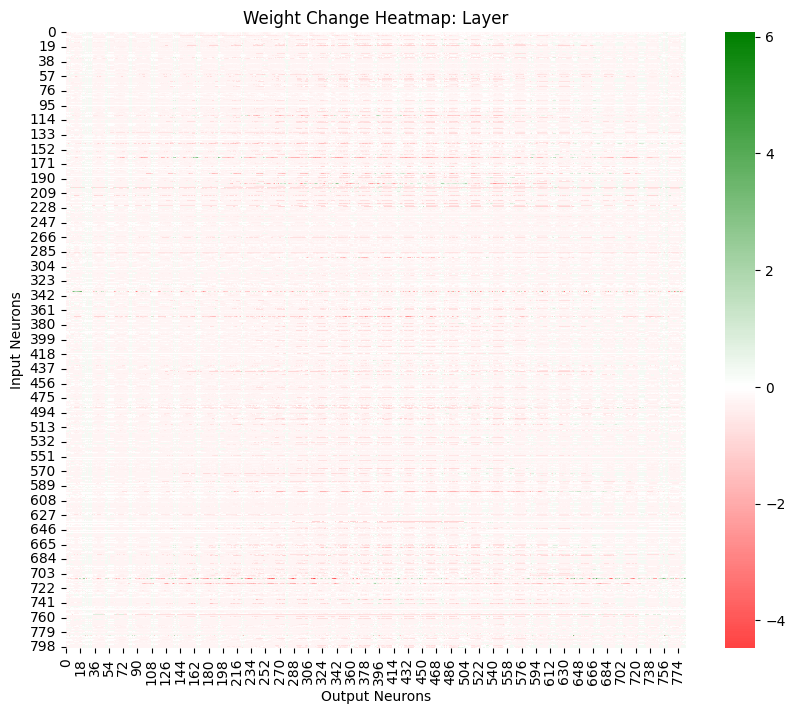

In [19]:
from visualize import visualize_weight_change

visualize_weight_change(weights_before=trained_ms[1].fc1.weight, weights_after=mu_ms[1].fc1.weight)

### Layer-wise Distance

In [20]:
from metrics import model_layer_wise_difference
lw_dist = {}
for t, mu in zip(trained_ms.values(), mu_ms.values()):
    new = model_layer_wise_difference(t, mu)
    if len(lw_dist) == 0:
        for name in new.keys():
            lw_dist[name] = []
    for name in new.keys():
        lw_dist[name].append(new[name])
for key in lw_dist.keys():
    lw_dist[key] = sum(lw_dist[key])/len(lw_dist[key])
lw_dist

{'fc1.weight': 154339.1359375,
 'fc1.bias': 254.94102427164714,
 'fc3.weight': 1991.9458984375,
 'fc3.bias': 18.424872875213623}

### KL-Divergence

Used to compare the difference between distribution, but may also be used to compare models by their predicted target distributions.

In [21]:
from metrics import kl_divergence_between_models, calc_mutlimodel_metric_average
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

#### Untrained to...

In [22]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.8857268601769275

#### Trained to...

In [23]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.2408357242842323

#### Exact ...

In [24]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.6872418675363933

#### MU to...

In [25]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

8.096080269469056

In [26]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

3.092435980152872

In [27]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

2.7974990629915655

### Accuracy

- $D_{Gesamt}$
- $D_{Erased}$
- $D_{Remain}$
- $D_{Accuracy Per Class}$

In [14]:
from visualize import boxplotting_multimodel_eval

accs = {}

Now, let us see what metrics each model has

Starts evaluation for 'fashion_mnist'...


Average Accuracy for D_gesamt: 0.5449 - Standard Deviation for D_gesamt: 0.0865


Average Accuracy for D_remain: 0.5524 - Standard Deviation for D_remain: 0.0893


Average Accuracy for 0: 0.3629 - Standard Deviation for 0: 0.4065


Average Accuracy for 1: 0.8493 - Standard Deviation for 1: 0.2342


Average Accuracy for 2: 0.5281 - Standard Deviation for 2: 0.4641


Average Accuracy for 3: 0.3676 - Standard Deviation for 3: 0.2833


Average Accuracy for 4: 0.2594 - Standard Deviation for 4: 0.3794


Average Accuracy for 6: 0.0701 - Standard Deviation for 6: 0.1317


Average Accuracy for 7: 0.8351 - Standard Deviation for 7: 0.0927


Average Accuracy for 8: 0.6145 - Standard Deviation for 8: 0.4030


Average Accuracy for 9: 0.9170 - Standard Deviation for 9: 0.0536


Average Accuracy for 5_all: 0.6452 - Standard Deviation for 5_all: 0.0863


Average Accuracy for 5_remain: 0.8103 - Standard Deviation for 5_remain: 0.0612


Average Accuracy for 5_erased: 0.3379 - Standard Deviation for 5_erased: 0.1655
plotting...


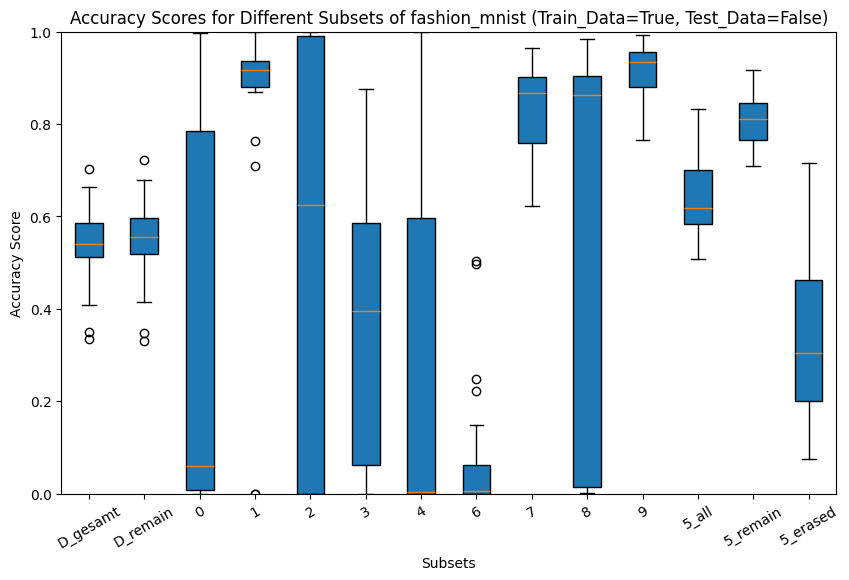

In [29]:
accs["mu_ms_train"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=True, test_split=False, logs=True)

Starts evaluation for 'fashion_mnist'...


Average Accuracy for D_gesamt: 0.5402 - Standard Deviation for D_gesamt: 0.0852


Average Accuracy for D_remain: 0.5481 - Standard Deviation for D_remain: 0.0880


Average Accuracy for 0: 0.3565 - Standard Deviation for 0: 0.4021


Average Accuracy for 1: 0.8398 - Standard Deviation for 1: 0.2323


Average Accuracy for 2: 0.5272 - Standard Deviation for 2: 0.4633


Average Accuracy for 3: 0.3586 - Standard Deviation for 3: 0.2772


Average Accuracy for 4: 0.2607 - Standard Deviation for 4: 0.3813


Average Accuracy for 6: 0.0668 - Standard Deviation for 6: 0.1275


Average Accuracy for 7: 0.8392 - Standard Deviation for 7: 0.0930


Average Accuracy for 8: 0.6091 - Standard Deviation for 8: 0.4007


Average Accuracy for 9: 0.9192 - Standard Deviation for 9: 0.0541


Average Accuracy for 5_all: 0.6248 - Standard Deviation for 5_all: 0.0867


Average Accuracy for 5_remain: 0.7959 - Standard Deviation for 5_remain: 0.0605


Average Accuracy for 5_erased: 0.3373 - Standard Deviation for 5_erased: 0.1624
plotting...


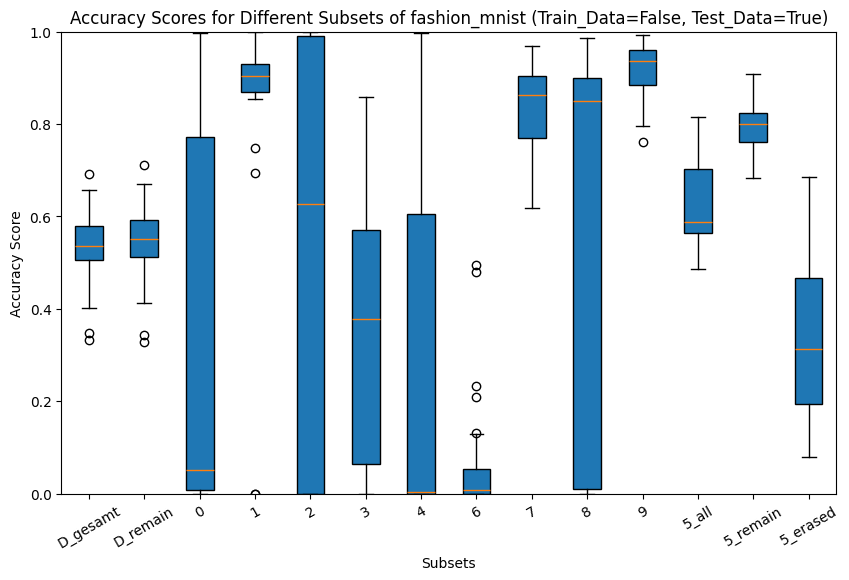

In [30]:
# can take like 80minutes
accs["mu_ms_test"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=False, test_split=True, logs=True)

#### Losses

In [15]:
losses = {}

Starts evaluation for 'fashion_mnist'...


Average loss for D_gesamt: 0.1497 - Standard Deviation for D_gesamt: 0.0244


Average loss for D_remain: 0.1373 - Standard Deviation for D_remain: 0.0235


Average loss for 0: 0.1796 - Standard Deviation for 0: 0.0572


Average loss for 1: 0.0857 - Standard Deviation for 1: 0.0672


Average loss for 2: 0.1963 - Standard Deviation for 2: 0.0288


Average loss for 3: 0.1707 - Standard Deviation for 3: 0.0563


Average loss for 4: 0.1943 - Standard Deviation for 4: 0.0367


Average loss for 6: 0.2225 - Standard Deviation for 6: 0.0360


Average loss for 7: 0.0704 - Standard Deviation for 7: 0.0436


Average loss for 8: 0.1213 - Standard Deviation for 8: 0.0740


Average loss for 9: 0.0360 - Standard Deviation for 9: 0.0225


Average loss for 5_all: 0.2198 - Standard Deviation for 5_all: 0.0911


Average loss for 5_remain: 0.0735 - Standard Deviation for 5_remain: 0.0253


Average loss for 5_erased: 0.4936 - Standard Deviation for 5_erased: 0.2402
plotting...


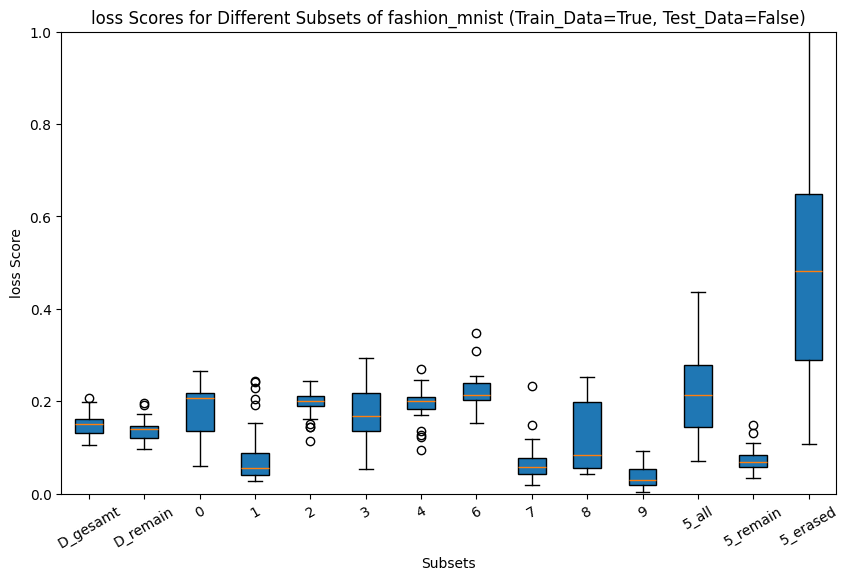

In [16]:
losses["mu_ms_train"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="loss", train_split=True, test_split=False, logs=True)

Starts evaluation for 'fashion_mnist'...


Average loss for D_gesamt: 0.1536 - Standard Deviation for D_gesamt: 0.0244


Average loss for D_remain: 0.1398 - Standard Deviation for D_remain: 0.0232


Average loss for 0: 0.1791 - Standard Deviation for 0: 0.0547


Average loss for 1: 0.0938 - Standard Deviation for 1: 0.0656


Average loss for 2: 0.1973 - Standard Deviation for 2: 0.0293


Average loss for 3: 0.1733 - Standard Deviation for 3: 0.0555


Average loss for 4: 0.1943 - Standard Deviation for 4: 0.0377


Average loss for 6: 0.2259 - Standard Deviation for 6: 0.0358


Average loss for 7: 0.0670 - Standard Deviation for 7: 0.0445


Average loss for 8: 0.1279 - Standard Deviation for 8: 0.0738


Average loss for 9: 0.0355 - Standard Deviation for 9: 0.0221


Average loss for 5_all: 0.2421 - Standard Deviation for 5_all: 0.0988


Average loss for 5_remain: 0.0830 - Standard Deviation for 5_remain: 0.0278


Average loss for 5_erased: 0.5137 - Standard Deviation for 5_erased: 0.2429
plotting...


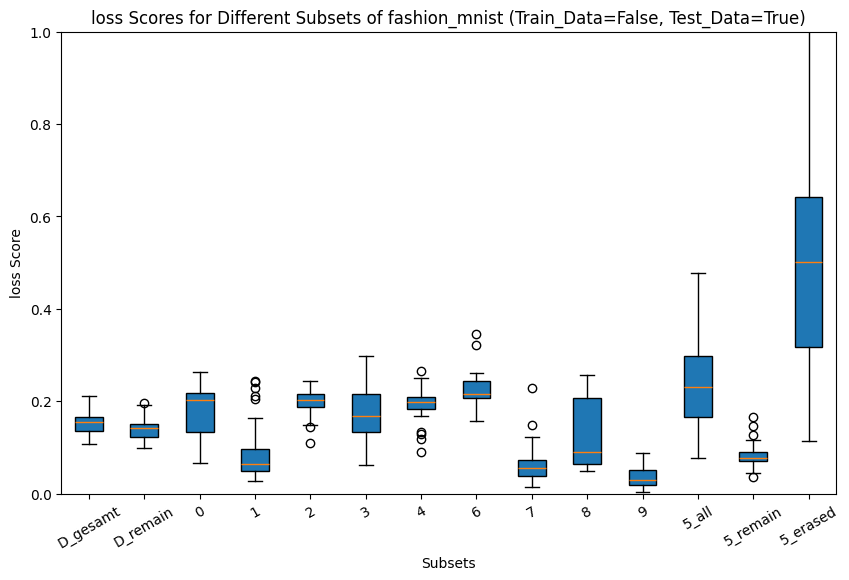

In [17]:
losses["mu_ms_test"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="loss", train_split=False, test_split=True, logs=True)